In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [2]:
# merge_ohlc_closing_prices(directory='binance_data/From_Paper/2023/1h')

In [3]:
prices = pd.read_csv("binance_data/From_Paper/2023/1h/merged_From_Paper_closing_prices.csv", index_col=0, parse_dates=True)

In [4]:
#Only use prices up until 2023-12-29

prices = prices.loc[:'2023-12-29']
prices

,BTCEUR_2023_1h,BTCGBP_2023_1h
timestamp,,
2023-01-01 00:00:00,15408.91,13669.49
2023-01-01 01:00:00,15425.19,13689.35
2023-01-01 02:00:00,15421.09,13676.01
2023-01-01 03:00:00,15409.20,13661.12
2023-01-01 04:00:00,15396.42,13655.23
...,...,...
2023-12-29 19:00:00,38214.50,35986.75
2023-12-29 20:00:00,38138.94,35986.75
2023-12-29 21:00:00,38074.20,35986.75


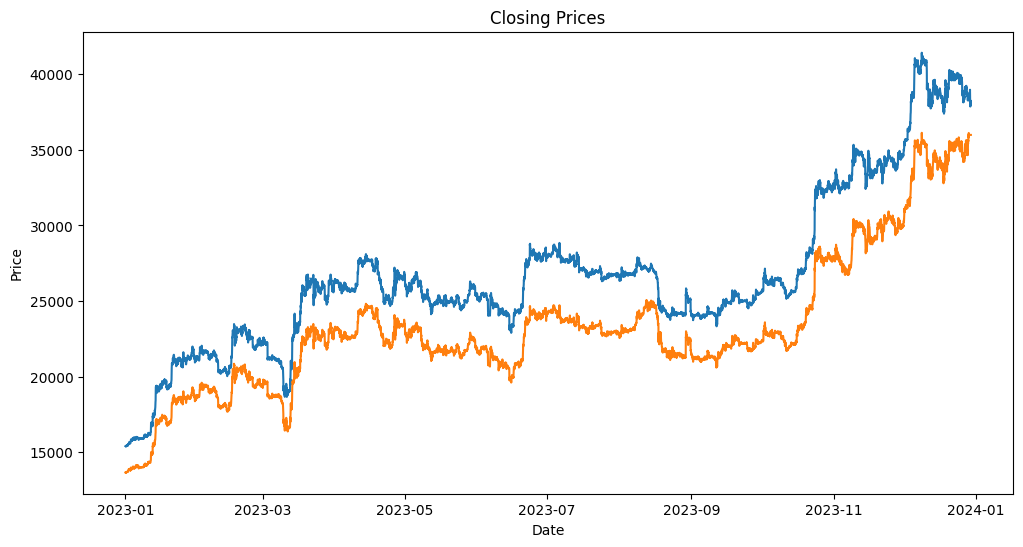

In [5]:
#Plot the closing prices
plt.figure(figsize=(12,6))
plt.plot(prices)
plt.title("Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [6]:
#Calculate correlation matrix
correlation_matrix = prices.corr()
correlation_matrix

,BTCEUR_2023_1h,BTCGBP_2023_1h
BTCEUR_2023_1h,1.000000,0.996223
BTCGBP_2023_1h,0.996223,1.000000


# Applly funnel and test for cointegration
---

In [20]:

# # Pre-filter: Calculate correlation matrix and select pairs with high correlation
# corr_threshold = 0.8
# corr_matrix, high_corr_pairs = filter_high_correlation_pairs(prices, threshold=corr_threshold)
# print(f"\nPairs with correlation >= {corr_threshold}:")
# for pair in high_corr_pairs:
#     print(f"{pair[0]} & {pair[1]}: correlation = {pair[2]:.4f}")

# # Cointegration test
# cointegrated_pairs, pvalue_matrix, residuals_df = find_cointegrated_pairs(prices, high_corr_pairs,significance=0.05)
# #cointegrated_pairs, window_results = find_cointegrated_pairs_windows(prices, high_corr_pairs, significance=0.05, window_size=720, min_pass_fraction=0.5)



Pairs with correlation >= 0.8:
BTCEUR_2023_1h & BTCGBP_2023_1h: correlation = 0.9962

No cointegrated pairs found among the high-correlation pairs.


In [8]:
# cointegrated_pairs = [('BNB/USDT_2024_1h',
#   'BTC/USDT_2024_1h',
#   0.731393,
#   0.8501886494196308)]

In [9]:
# #If you suspect daily intraday patterns, using 24 lags is a natural choice: it checks each hour in a 24-hour cycle for dependence.
# #If your sample is large enough (covering many days/weeks), 24 lags is typically enough to detect standard intraday correlation
# analyze_residuals(residuals_df, lags = 24)

In [10]:
# cointegrated_pairs

# Test cointegration function on data designed to be cointegrated
---

In [11]:
# import numpy as np
# import pandas as pd

# def generate_cointegrated_data(
#     n=720,  # number of data points
#     alpha=5.0,
#     beta=1.5,
#     phi=0.8,
#     seed=42
# ):
#     """
#     Generate two cointegrated series: S1 (random walk) and S2 (linear function of S1 + stationary AR(1) noise).
    
#     Parameters:
#         n (int): Number of observations (e.g. 720 for ~1 month of hourly data).
#         alpha (float): Intercept term for S2.
#         beta (float): S2 coefficient for S1.
#         phi (float): AR(1) coefficient for the noise in S2 - beta*S1. Must be <1 in abs value for stationarity.
#         seed (int): Random seed for reproducibility.

#     Returns:
#         pd.DataFrame with columns ['S1', 'S2'] representing the two cointegrated time series.
#     """
#     rng = np.random.default_rng(seed)
    
#     # 1) Generate S1 as a random walk
#     #   S1_t = S1_{t-1} + e1_t
#     e1 = rng.normal(loc=0.0, scale=1.0, size=n)
#     S1 = np.cumsum(e1)  # cumsum => random walk
    
#     # 2) Generate a stationary AR(1) noise for the spread
#     #   ARnoise_t = phi * ARnoise_{t-1} + e2_t
#     e2 = rng.normal(loc=0.0, scale=1.0, size=n)
#     ARnoise = np.zeros(n)
#     for t in range(1, n):
#         ARnoise[t] = phi * ARnoise[t-1] + e2[t]
#     # ARnoise is stationary if |phi| < 1
    
#     # 3) Define S2 = alpha + beta*S1 + AR(1) noise
#     S2 = alpha + beta*S1 + ARnoise
    
#     # Put them in a DataFrame
#     df = pd.DataFrame({'S1': S1, 'S2': S2})
#     return df

# # Example usage
# if __name__ == "__main__":
#     df_cointegrated = generate_cointegrated_data(n=720)
#     print(df_cointegrated.head(10))


In [12]:
# # Suppose df has columns: 'S1', 'S2'
# alpha = 5.0
# beta = 1.5

# # Calculate the spread: S2 - (alpha + beta * S1)
# df_cointegrated['spread'] = df_cointegrated['S2'] - alpha - beta * df_cointegrated['S1']

# # Plot
# plt.figure(figsize=(10,6))
# plt.plot(df_cointegrated['spread'], label='Spread = S2 - alpha - beta*S1')
# plt.axhline(df_cointegrated['spread'].mean(), color='red', linestyle='--', label='Mean')
# plt.title('Spread Over Time')
# plt.legend()
# plt.show()


# Windows
---

### On data designed to be cointegrated

In [13]:
high_corr_pairs = []

In [14]:
# cointegrated_pairs, window_results = find_cointegrated_pairs_windows(df_cointegrated, high_corr_pairs, significance=0.05, window_size=240, min_pass_fraction=0.5)

In [15]:
# window_results

# Test cointegration on actual data
---

In [16]:
cointegrated_pairs, window_results = find_cointegrated_pairs_windows(prices, high_corr_pairs, significance=0.05, window_size=720, min_pass_fraction=0.5)


No cointegrated pairs found across the windows.


In [17]:
window_results

{('BTCEUR_2023_1h', 'BTCGBP_2023_1h'): [np.float64(0.27953546083422764),
  np.float64(0.4944795965945168),
  np.float64(0.22764520604151456),
  np.float64(0.33184106310455974),
  np.float64(0.19627809661138473),
  np.float64(0.012871902023342978),
  np.float64(0.41478919911173484),
  np.float64(0.6400228763221817),
  np.float64(0.0818487485091578),
  np.float64(0.3859435871822846),
  np.float64(0.10420299066376881),
  np.float64(0.9676123743049139)]}

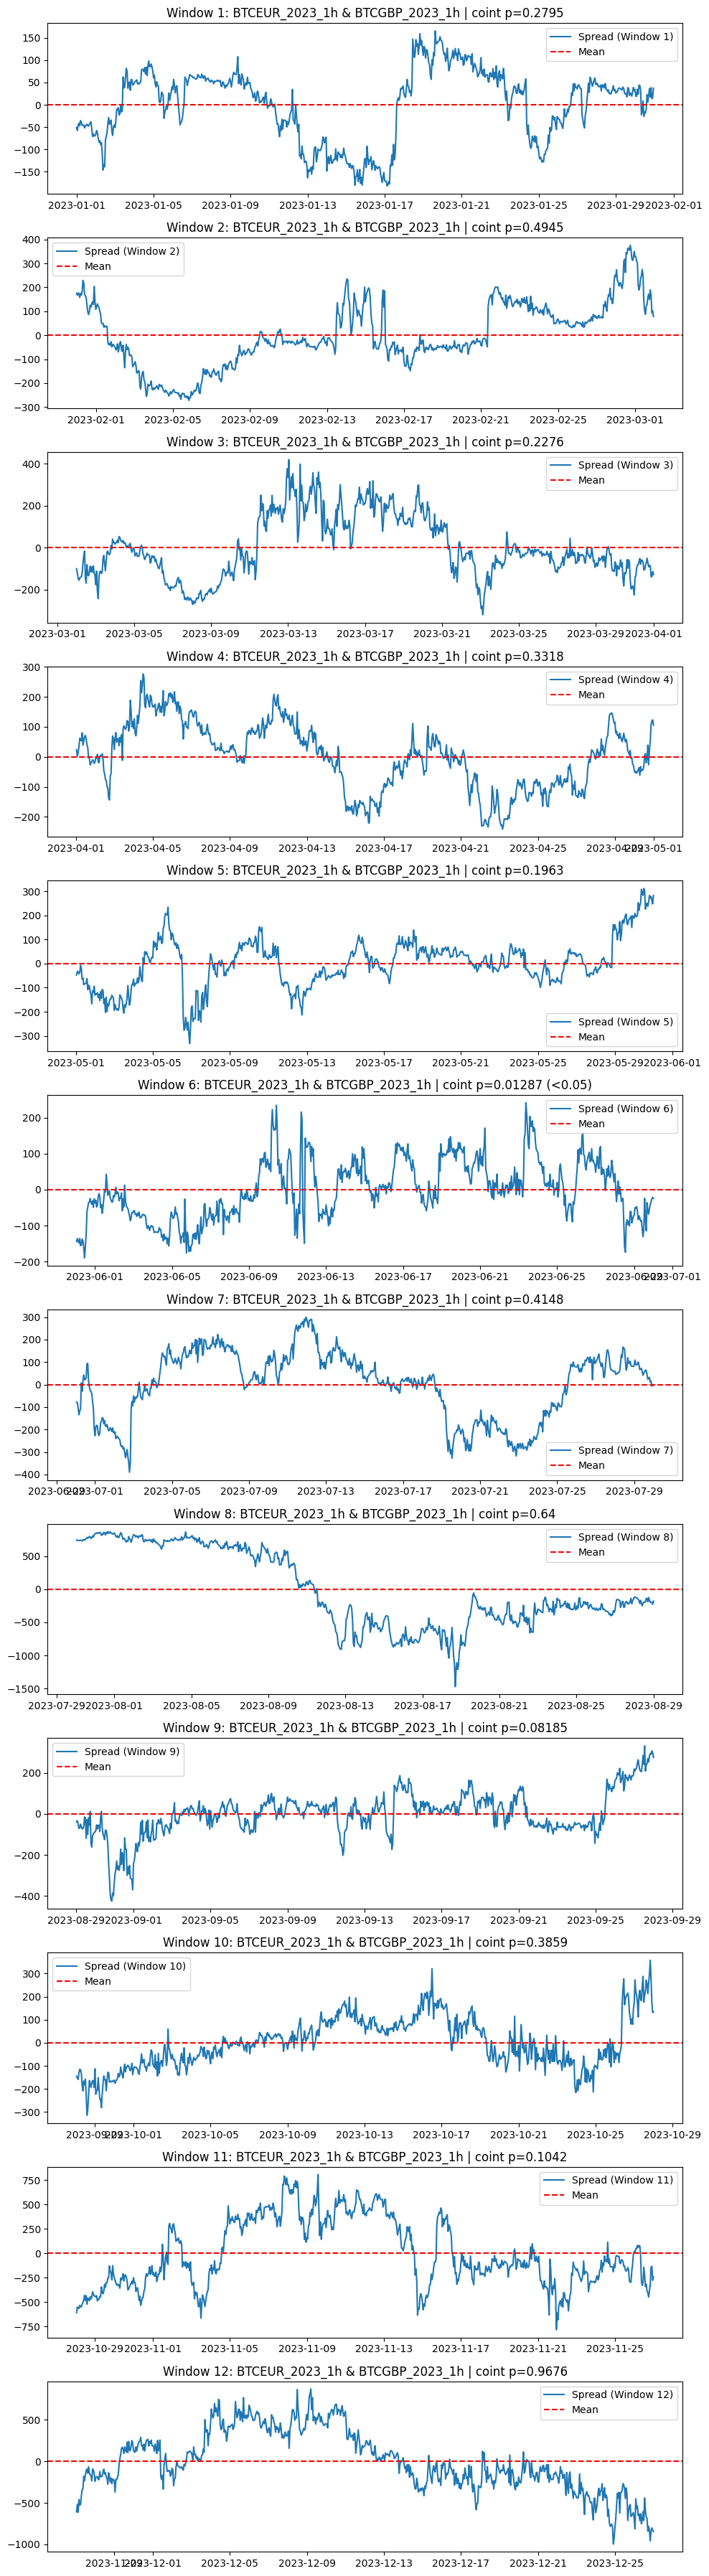

In [19]:
windows = split_price_series_into_windows(prices, window_size=720)

#For ICP/USDT_2024_1h', 'ADA/USDT_2024_1h
plot_spread_in_windows('BTCEUR_2023_1h', 'BTCGBP_2023_1h', windows, window_results, significance=0.05)
#plot_spread_in_windows('S1', 'S2', windows, window_results, significance=0.05)

# New Code

In [15]:
# if cointegrated_pairs:
#         sym1, sym2, pvalue, corr_val = cointegrated_pairs[0]
#         print(f"\nTesting strategy on pair: {sym1} and {sym2} (p-value: {pvalue:.4f}, correlation: {corr_val:.4f})")
#         S1 = prices[sym1]
#         S2 = prices[sym2]

#         #Only look at the first 1000 points for now
#         S1 = S1[:720]
#         S2 = S2[:720]
        
#         # Compute the spread series and beta_series 
#         spread_series, beta_series = compute_spread_series(S1, S2, window_size=720)
#         #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
        
#         # Generate trading signals based on the spread's z-score
#         zscore_series, positions_series = backtest_pair_rolling(spread_series, window_size=720, entry_threshold=1.0, exit_threshold=0.0)
        
#         # Simulate strategy performance
#         #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)
        
#         pnl, cum_pnl = simulate_true_strategy_rolling(S1, S2, positions_series, beta_series)
        
#         #Plot trading simulation
#         plot_trading_simulation(S1, S2, sym1,sym2,zscore_series, positions_series, cum_pnl)

## OLD CODE

In [16]:
# if cointegrated_pairs:
#         sym1, sym2, pvalue, corr_val = cointegrated_pairs[0]
#         print(f"\nTesting strategy on pair: {sym1} and {sym2} (p-value: {pvalue:.4f}, correlation: {corr_val:.4f})")
#         S1 = prices[sym1]
#         S2 = prices[sym2]

#         #Only look at the first 1000 points for now
#         # S1 = S1[:720]
#         # S2 = S2[:720]
        
#         # Compute the spread and hedge ratio
#         spread, beta = compute_spread(S1, S2)
#         print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
        
#         # Generate trading signals based on the spread's z-score
#         zscore, positions = backtest_pair(spread, entry_threshold=1, exit_threshold=0.0)
        
#         # Simulate strategy performance
#         #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)

#         pnl, cum_pnl = simulate_true_strategy(S1, S2, positions, beta)
        
#         #Plot trading simulation
#         plot_trading_simulation(S1, S2, sym1,sym2,zscore, positions, cum_pnl)

In [17]:
# spread_series, beta_series = compute_spread_series(S1, S2, window_size=720)